In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import data_processing as dp

In [2]:
qfs = pd.read_json("../data/output_data/qwen_fs.json")
qzs = pd.read_json("../data/output_data/qwen_zs.json")
mfs = pd.read_json("../data/output_data/mu_fs.json")
mzs = pd.read_json("../data/output_data/mu_zs.json")

qfs = dp.parse_df(qfs, experiment_name="qwen_fs")
qzs = dp.parse_df(qzs, experiment_name="qwen_zs")
mfs = dp.parse_df(mfs, experiment_name="mu_fs")
mzs = dp.parse_df(mzs, experiment_name="mu_zs")

print("qfs accuracy =", utils.accuracy(qfs))
print("qzs accuracy =", utils.accuracy(qzs))
print("mfs accuracy =", utils.accuracy(mfs))
print("mzs accuracy =", utils.accuracy(mzs))

NameError: name 'utils' is not defined

In [4]:
len(qfs), len(qzs), len(mfs), len(mzs)

(844, 846, 844, 846)

In [5]:
mfs.isna().sum()

id                      0
prompt                  0
answers                 0
answer_orders           0
dataset                 0
genre                   0
reasoning               0
knowledge               0
audio_path              0
model_output            0
output_folder           0
n_question_tokens       0
n_audio_tokens          0
extracted_response      0
final_answer            0
question                0
a_shap                140
t_shap                140
input_tokens            0
output_tokens           0
input_ids               0
experiment              0
len_output              0
n_output_tokens         0
dtype: int64

In [6]:
qfs["a_shap"].median(), qzs["a_shap"].median(), mfs["a_shap"].median(), mzs["a_shap"].median()

(0.23066184552268001,
 0.2100249768852444,
 0.4837614259579978,
 0.47246444578399144)

In [7]:
agg_df = pd.concat([qzs, qfs, mfs, mzs])

## A-SHAP Metrics
agg_df.groupby(["experiment"]).agg({"a_shap": ["median", "mean", "std", "max", "min"]})

a_shap                                        
              median      mean       std       max       min
experiment                                                  
mu_fs       0.483761  0.483944  0.024013  0.550254  0.395354
mu_zs       0.472464  0.472186  0.025605  0.568076  0.396400
qwen_fs     0.230662  0.232441  0.026172  0.322845  0.100364
qwen_zs     0.210025  0.211370  0.028940  0.336418  0.101766

In [8]:
agg_df.groupby(["experiment", "final_answer"]).agg({"a_shap": ["median", "mean", "std", "max", "min"]})

a_shap                                        
                           median      mean       std       max       min
experiment final_answer                                                  
mu_fs      -1            0.483145  0.483163  0.027290  0.535285  0.395354
            0            0.483355  0.483753  0.023354  0.550254  0.410082
            1            0.484356  0.484685  0.023041  0.542654  0.428253
mu_zs      -1            0.472623  0.473043  0.026931  0.568076  0.396400
            0            0.473613  0.473234  0.024436  0.542596  0.407400
            1            0.471523  0.470115  0.026791  0.530327  0.404678
qwen_fs    -1            0.233955  0.235950  0.027204  0.322845  0.184376
            0            0.229072  0.230943  0.026052  0.307442  0.100364
            1            0.230673  0.232153  0.025729  0.313112  0.155525
qwen_zs    -1            0.213981  0.217573  0.033846  0.336418  0.140104
            0            0.210392  0.210734  0.027313  0.306789  0.129533
            1            0.208197  0.210181  0.028653  0.318637  0.101766

### What is the IFR per experiment?
Instruction Following Rate (IFR) reflects how much a model follows the prompt format. In our case, is how much the models actually give a response that we can consider right/wrong

In [9]:
agg_df['answer_group'] = agg_df['final_answer'].map({-1: '-1', 0: '0-1', 1: '0-1'})

# Then group by experiment and the new group
ifr = (agg_df.groupby(['experiment', 'answer_group'])
                .agg(count=('id', 'count'))
                .assign(percentage=lambda x: x.groupby(level=0)['count']
                                             .transform(lambda g: g / g.sum() * 100))
                .reset_index())

ifr

,experiment,answer_group,count,percentage
0,mu_fs,-1,271,32.109005
1,mu_fs,0-1,573,67.890995
2,mu_zs,-1,135,15.957447
3,mu_zs,0-1,711,84.042553
4,qwen_fs,-1,164,19.431280
5,qwen_fs,0-1,680,80.568720
6,qwen_zs,-1,111,13.120567
7,qwen_zs,0-1,735,86.879433


In [10]:
qfs.isnull().values.any(), qzs.isnull().values.any(), mfs.isnull().values.any(),  mzs.isnull().values.any()

(False, False, True, True)

## Check average answer length for different experiments

In [11]:
agg_df = pd.concat([qzs, qfs, mfs, mzs])

In [12]:
len(agg_df["input_tokens"].iloc[0])

54

In [13]:
agg_df.groupby("experiment").agg({"len_output": "mean", "n_output_tokens": "mean", "a_shap": "mean"})

,len_output,n_output_tokens,a_shap
experiment,,,
mu_fs,52.117299,12.481043,0.483944
mu_zs,57.509456,13.643026,0.472186
qwen_fs,77.048578,16.354265,0.232441
qwen_zs,97.611111,20.334515,0.211370


In [14]:
# pivot table for easier viz
tmp = agg_df.groupby(["experiment", "genre"]).agg({"n_output_tokens": "mean", "a_shap": "mean"})
tmp = tmp.reset_index()  

pivoted_df = tmp.set_index(['genre', 'experiment']).unstack(level='experiment')
pivoted_df = pivoted_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

pivoted_df

experiment                 mu_fs                     mu_zs                  \
                          a_shap n_output_tokens    a_shap n_output_tokens   
genre                                                                        
Blues                   0.486792       14.000000  0.468543       15.333333   
Classical               0.482207       11.888889  0.472945       13.916667   
Electronic              0.482463       14.554688  0.471927       13.742188   
Folk, World, & Country  0.484319       12.170370  0.470800       14.021898   
Funk / Soul             0.483139       10.557692  0.471730       13.096154   
Hip Hop                 0.481228       12.062500  0.472135       12.796875   
Jazz                    0.486319       12.225000  0.470450       12.825000   
Latin                   0.486092       15.586957  0.478169       14.413043   
Pop                     0.484552       10.764228  0.472989       13.837398   
Reggae                  0.485202       10.977778  0.472187       12.333333   
Rock                    0.484061       12.757962  0.472064       13.707006   

experiment               qwen_fs                   qwen_zs                  
                          a_shap n_output_tokens    a_shap n_output_tokens  
genre                                                                       
Blues                   0.240911       18.500000  0.232673       19.888889  
Classical               0.221466       20.277778  0.209616       22.583333  
Electronic              0.224698       16.133858  0.206650       24.445312  
Folk, World, & Country  0.233150       16.043796  0.215474       19.335766  
Funk / Soul             0.237382       16.365385  0.212324       19.884615  
Hip Hop                 0.233059       15.406250  0.206631       17.953125  
Jazz                    0.232353       18.025000  0.208766       25.275000  
Latin                   0.237787       18.956522  0.219708       22.217391  
Pop                     0.236355       15.252033  0.210394       16.845528  
Reggae                  0.231681       17.500000  0.210760       20.866667  
Rock                    0.233346       15.394904  0.210371       19.280255

# Is there a relationship between the type of question and the A-SHAP?

In [15]:
question_type_df = agg_df.explode("knowledge").explode("reasoning")

In [16]:
question_type_df.iloc[0]

id                                                          FENJIDecy5s
prompt                Question: What type of sound is used for the b...
answers               [Analog bass sound, The bassline repeats, Digi...
answer_orders                                              [1, 2, 0, 3]
dataset                                                       musiccaps
genre                                                        Electronic
reasoning                                                           NaN
knowledge                                                 sound texture
audio_path                           musiccaps/audio/FENJIDecy5s_80.wav
model_output          The type of sound used for the bassline in thi...
output_folder         data/output_data/qwenaudio_muchomusic_musiccap...
n_question_tokens                                                    54
n_audio_tokens                                                       54
extracted_response                                              

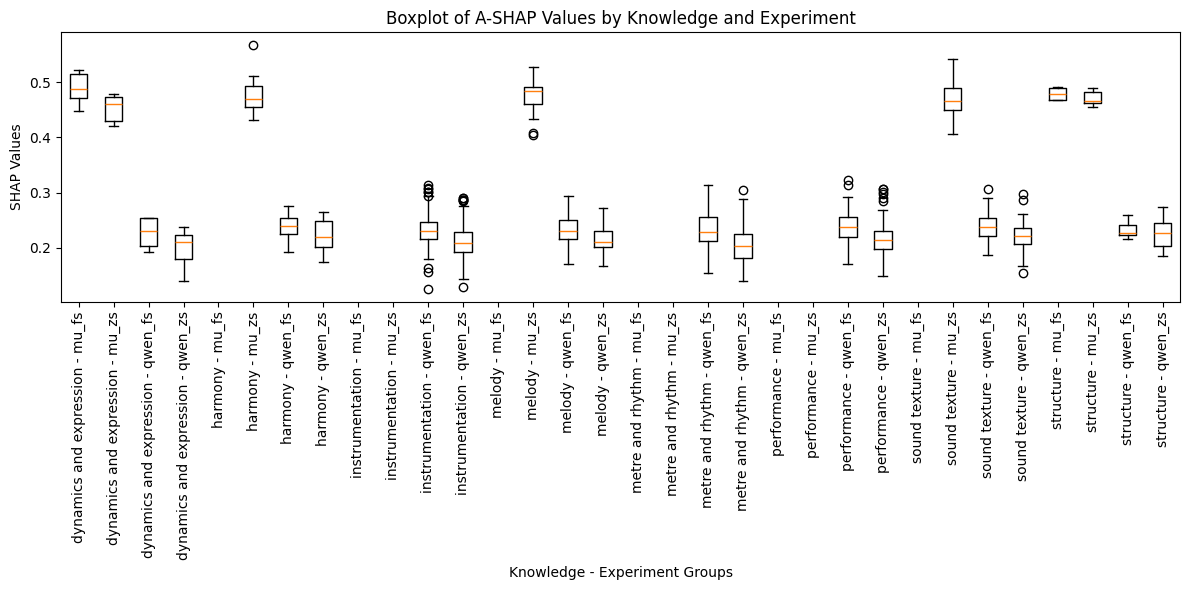

In [17]:
# Group the data
grouped = question_type_df.groupby(['knowledge', 'experiment'])['a_shap']

# Prepare data for boxplot
data = [group.values for name, group in grouped]
labels = [f"{k} - {e}" for (k, e), group in grouped]

# Create boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(data, tick_labels=labels)
plt.xlabel('Knowledge - Experiment Groups')
plt.ylabel('SHAP Values')
plt.title('Boxplot of A-SHAP Values by Knowledge and Experiment')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

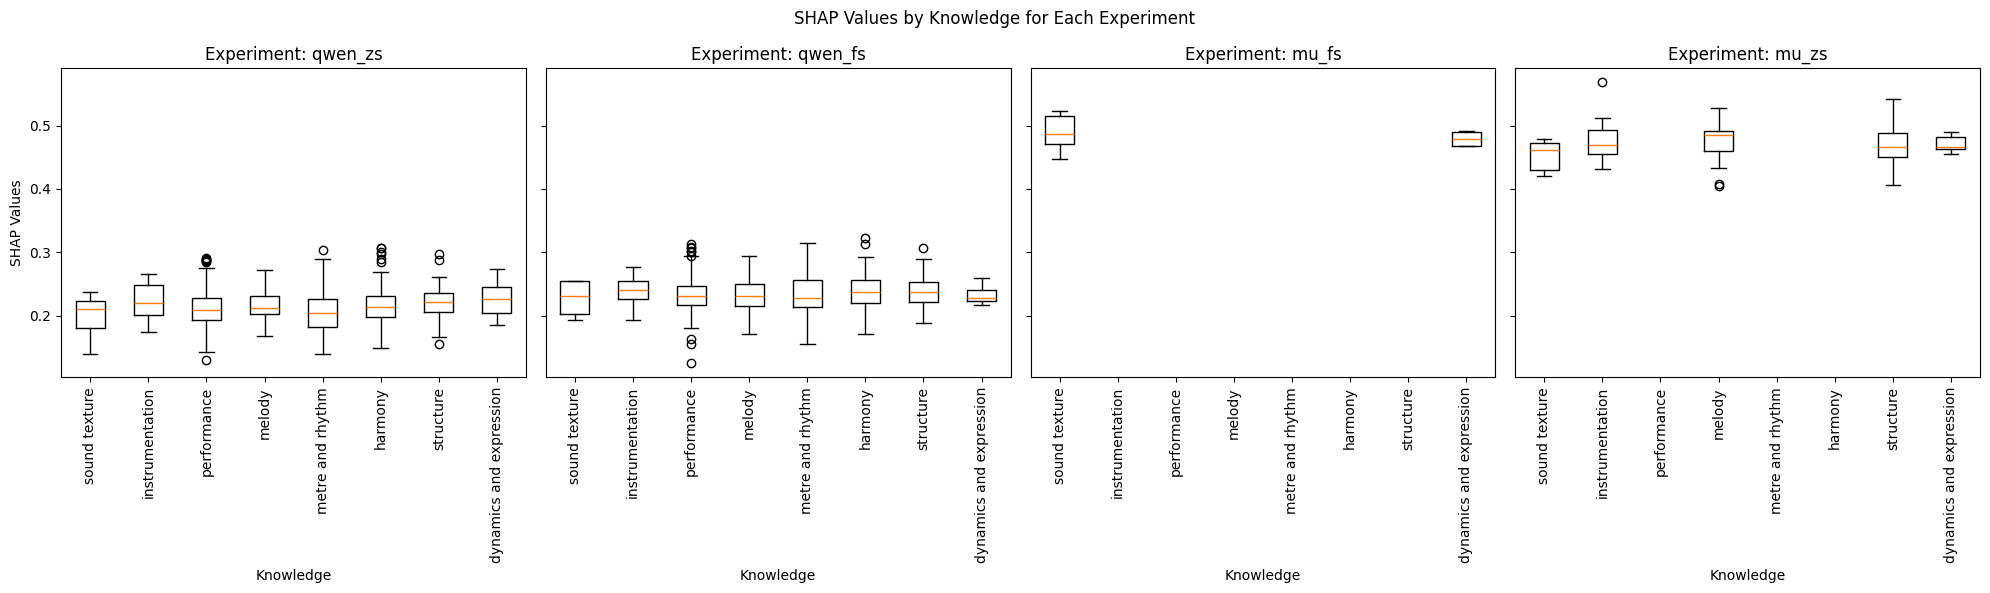

In [18]:
### SHOULD I BREAK THIS DOWN BY ANSWER (CORRECT/INCORRECT)?
# Get unique experiments
experiments = question_type_df['experiment'].unique()
n_experiments = len(experiments)

# Create subplots
fig, axes = plt.subplots(1, n_experiments, figsize=(5*n_experiments, 6), sharey=True)

# If only one experiment, axes won't be an array
if n_experiments == 1:
    axes = [axes]

# Create a boxplot for each experiment
for i, exp in enumerate(experiments):
    # Filter data for current experiment
    exp_data = question_type_df[question_type_df['experiment'] == exp]
    
    # Group by knowledge and get SHAP values for boxplot
    data = [group['a_shap'].values for name, group in exp_data.groupby('knowledge')]
    labels = exp_data['knowledge'].dropna().unique()
    
    # Create boxplot
    axes[i].boxplot(data, tick_labels=labels)
    axes[i].set_title(f'Experiment: {exp}')
    axes[i].set_xlabel('Knowledge')
    axes[i].tick_params(axis='x', rotation=90)

    if i == 0:
        axes[i].set_ylabel('SHAP Values')

plt.suptitle('SHAP Values by Knowledge for Each Experiment')
plt.tight_layout()
plt.show()

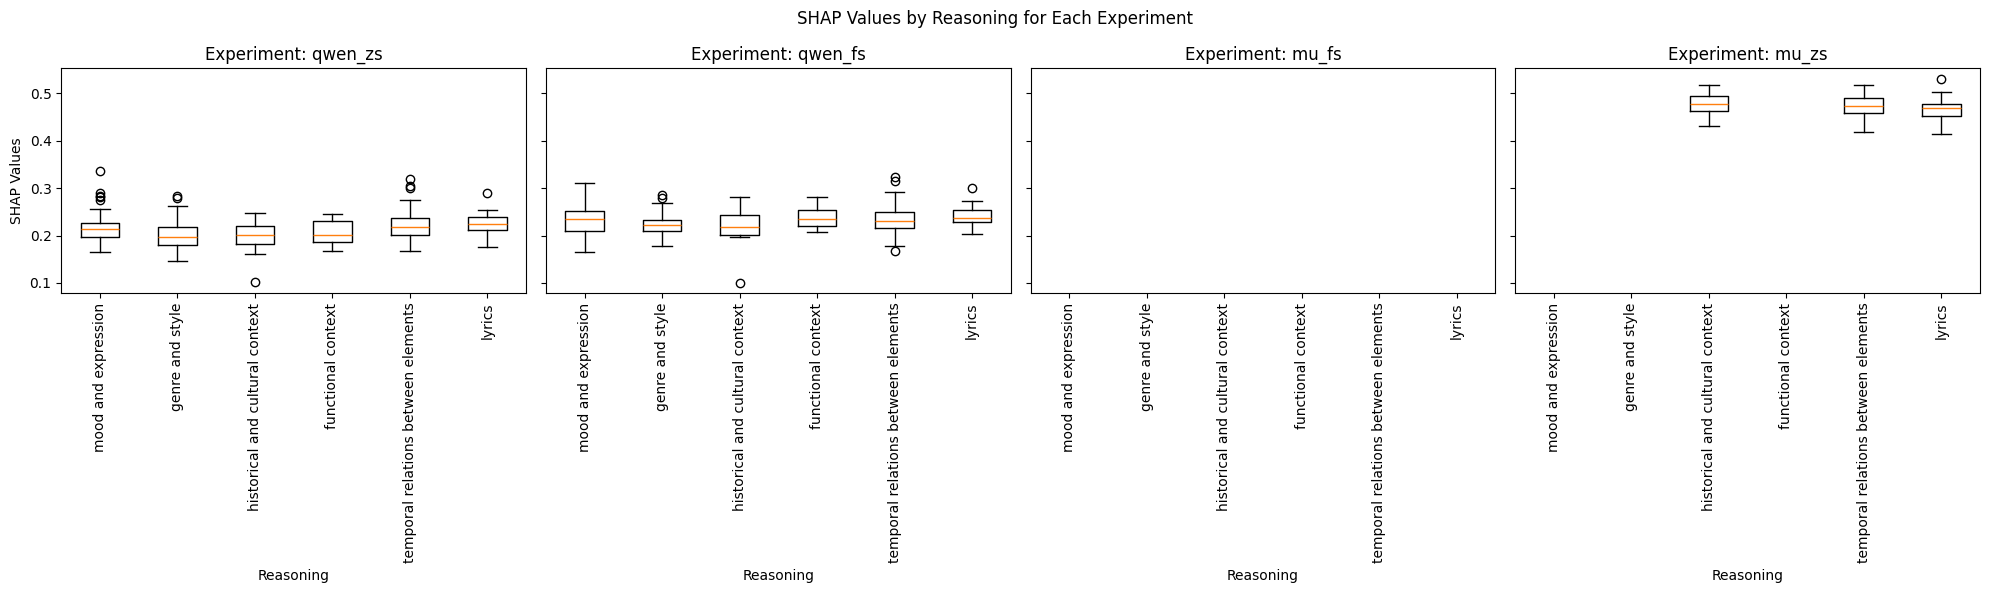

In [19]:
# Get unique experiments
experiments = question_type_df['experiment'].unique()
n_experiments = len(experiments)

# Create subplots
fig, axes = plt.subplots(1, n_experiments, figsize=(5*n_experiments, 6), sharey=True)

# If only one experiment, axes won't be an array
if n_experiments == 1:
    axes = [axes]

# Create a boxplot for each experiment
for i, exp in enumerate(experiments):
    # Filter data for current experiment
    exp_data = question_type_df[question_type_df['experiment'] == exp]
    
    # Group by knowledge and get SHAP values for boxplot
    data = [group['a_shap'].values for name, group in exp_data.groupby('reasoning')]
    labels = exp_data['reasoning'].dropna().unique()
    
    # Create boxplot
    axes[i].boxplot(data, tick_labels=labels)
    axes[i].set_title(f'Experiment: {exp}')
    axes[i].set_xlabel('Reasoning')
    axes[i].tick_params(axis='x', rotation=90)

    if i == 0:
        axes[i].set_ylabel('SHAP Values')

plt.suptitle('SHAP Values by Reasoning for Each Experiment')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'a_shap'}, xlabel='[knowledge, experiment]'>

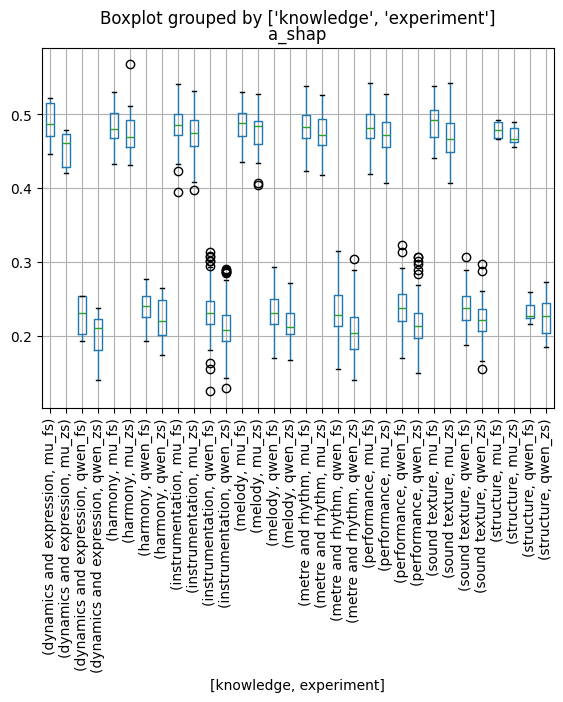

In [20]:
question_type_df[["knowledge", "experiment", "a_shap"]].boxplot(by=["knowledge", "experiment"], rot=90)

<Axes: xlabel='knowledge'>

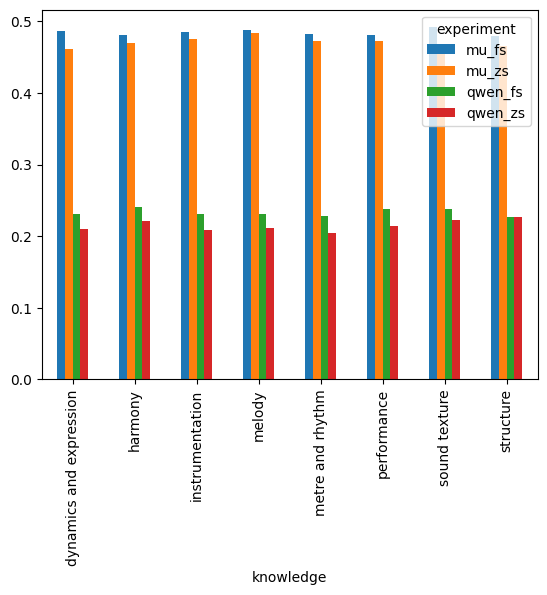

In [21]:
question_type_df.groupby(["knowledge", "experiment"]).agg(
    {
        # "n_output_tokens": "mean", 
        "a_shap": "median",
        # "prompt": "count"
    }
).unstack(level=1).plot(kind="bar", y="a_shap", use_index=True)

In [22]:
question_type_df.groupby(["reasoning", "experiment"]).agg({"n_output_tokens": "mean", "a_shap": ["mean", "std", "max", "min"]})

n_output_tokens    a_shap  \
                                                          mean      mean   
reasoning                           experiment                             
functional context                  mu_fs            18.888889  0.482145   
                                    mu_zs            15.714286  0.473533   
                                    qwen_fs          29.904762  0.234075   
                                    qwen_zs          41.206349  0.216499   
genre and style                     mu_fs            12.861314  0.487041   
                                    mu_zs            12.891304  0.471372   
                                    qwen_fs          14.681159  0.222361   
                                    qwen_zs          19.855072  0.200553   
historical and cultural context     mu_fs            12.555556  0.485361   
                                    mu_zs            14.526316  0.478156   
                                    qwen_fs          14.789474  0.219651   
                                    qwen_zs          17.000000  0.199128   
lyrics                              mu_fs            11.200000  0.469699   
                                    mu_zs            10.200000  0.456943   
                                    qwen_fs          12.133333  0.238878   
                                    qwen_zs          43.666667  0.206112   
mood and expression                 mu_fs            14.796992  0.485364   
                                    mu_zs            16.345865  0.473018   
                                    qwen_fs          18.348485  0.234814   
                                    qwen_zs          26.436090  0.221079   
temporal relations between elements mu_fs            13.263158  0.481457   
                                    mu_zs            13.631579  0.467831   
                                    qwen_fs          21.294118  0.241292   
                                    qwen_zs          30.368421  0.223511   

                                                                              
                                                     std       max       min  
reasoning                           experiment                                
functional context                  mu_fs       0.028458  0.550254  0.410082  
                                    mu_zs       0.026725  0.527718  0.396400  
                                    qwen_fs     0.029871  0.311090  0.164491  
                                    qwen_zs     0.031172  0.336418  0.164382  
genre and style                     mu_fs       0.025035  0.538591  0.411707  
                                    mu_zs       0.024955  0.530327  0.413670  
                                    qwen_fs     0.020735  0.285453  0.177917  
                                    qwen_zs     0.026932  0.283968  0.145540  
historical and cultural context     mu_fs       0.027765  0.550254  0.438447  
                                    mu_zs       0.021822  0.517402  0.432185  
                                    qwen_fs     0.038227  0.280845  0.100364  
                                    qwen_zs     0.033905  0.247810  0.101766  
lyrics                              mu_fs       0.025347  0.514421  0.435291  
                                    mu_zs       0.025266  0.497925  0.412049  
                                    qwen_fs     0.021164  0.280827  0.206859  
                                    qwen_zs     0.026257  0.246064  0.167290  
mood and expression                 mu_fs       0.023816  0.536415  0.438564  
                                    mu_zs       0.023711  0.518133  0.417825  
                                    qwen_fs     0.026470  0.322845  0.166923  
                                    qwen_zs     0.027336  0.318637  0.166823  
temporal relations between elements mu_fs       0.020294  0.514425  0.433668  
                                    mu_zs       0.027880  0.531376  0.415052  
                   

<Axes: xlabel='knowledge,experiment'>

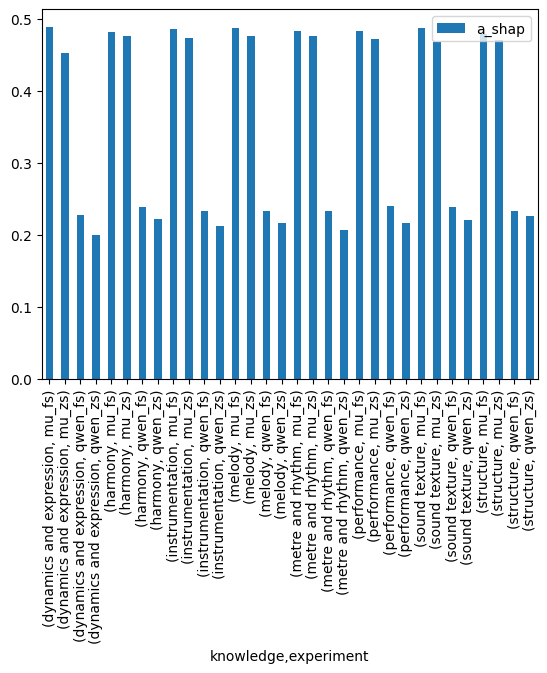

In [23]:
question_type_df.groupby(["knowledge", "experiment"]).agg({"a_shap": "mean"}).plot.bar()

# Is there a relationship between number of output tokens and A-SHAP value?
From a first glimpse, It looked like yes. But after plotting the results below, I don't think that we have a relationship. I think that the stronger relationship might appear if we remove stopwords from the answer rather than just checking the lenght of the answer itself.

Also, by doing this analysis I found some outliers that I was not expecting. This could be biasing the average length of the output, so I changed it from mean to median. In here, I remove the outliers to maybe have a better interpretation of the plots. I left an outlier example by the end of this section.

Text(0.5, 0.98, 'Number of output tokens vs A-SHAP')

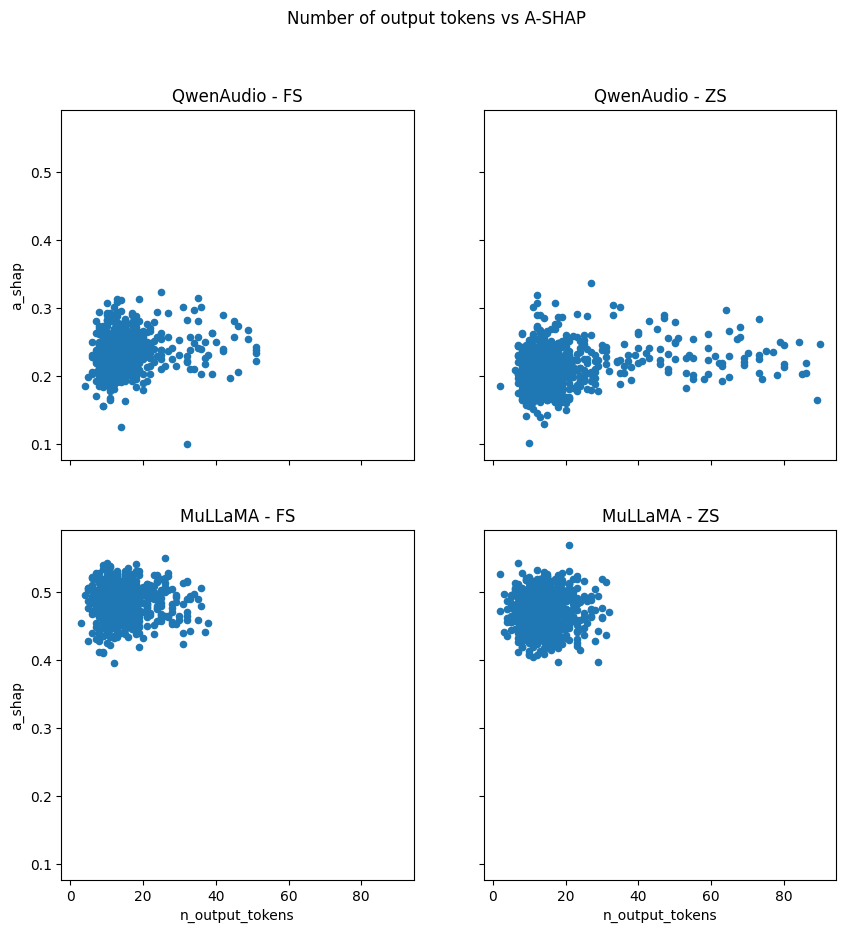

In [26]:
fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True, sharex=True)

# QwenAudio - few shot wo outliers
(
    qfs[np.abs(stats.zscore(qfs["n_output_tokens"])) < 3][["n_output_tokens", "a_shap"]]
        .sort_values(by="n_output_tokens")
        .plot.scatter(x="n_output_tokens", y="a_shap", ax=ax[0][0])
)
ax[0][0].set(title="QwenAudio - FS")

# QwenAudio - zero shot
(
    qzs[np.abs(stats.zscore(qzs["n_output_tokens"])) < 3]
        .sort_values(by="n_output_tokens").plot.scatter(x="n_output_tokens", y="a_shap", ax=ax[0][1])
)
ax[0][1].set(title="QwenAudio - ZS")

# MuLlaMA - few shot wo outliers
(
    mfs[np.abs(stats.zscore(mfs["n_output_tokens"])) < 3][["n_output_tokens", "a_shap"]]
        .sort_values(by="n_output_tokens")
        .plot.scatter(x="n_output_tokens", y="a_shap", ax=ax[1][0])
)
ax[1][0].set(title="MuLLaMA - FS")

# MuLLaMA - zero shot wo outliers
(
    mzs[np.abs(stats.zscore(mzs["n_output_tokens"])) < 3][["n_output_tokens", "a_shap"]]
        .sort_values(by="n_output_tokens")
        .plot.scatter(x="n_output_tokens", y="a_shap", ax=ax[1][1])
)
ax[1][1].set(title="MuLLaMA - ZS")

fig.suptitle("Number of output tokens vs A-SHAP")

### Example of the answer with the maximum number of tokens of each experiment

In [27]:
# qwen - few shot
qfs.loc[qfs[["n_output_tokens"]].idxmax()]["model_output"].values

array(['Based on the song\'s style, rhythm, and instrumentation, it is most likely that this recording was made outside busking with a band. The song features a traditional Indian percussion instrument called the tabla playing a fast-paced rhythm along with a digital drum beat. The digital drum is playing a four-on-the-floor rhythm pattern, which is a common pattern in pop music. The song also features a male vocalist singing in a foreign language, which is common in busking settings. Therefore, option (C) "Outside busking with a band" is the most likely answer.'],
      dtype=object)

In [28]:
# qwen - zero shot
qzs.loc[qzs[["n_output_tokens"]].idxmax()]["model_output"].values

array(['Based on the voice, it sounds like the vocals are in a French accent, saying, "J\'ai toujours été heureux, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, 

In [29]:
# mu - few shot
mfs.loc[mfs[["n_output_tokens"]].idxmax()]["model_output"].values

array(['(A) Flat female vocal, wide background harmonizing vocals (B) Saxophone solo (C) Uptempo and energetic overall feel (D) Acoustic rhythm guitar, offbeat shimmering open hats, claps, offbeat synth keys chords, groovy bass'],
      dtype=object)

In [30]:
# mu - zero shot
mzs.loc[mzs[["n_output_tokens"]].idxmax()]["model_output"].values

array(['The music has a lot of unrelated sound effects, such as an organ playing sustained chords and a rhythmic part, noises associated with doors opening and closing, background chattering of birds and crickets, and various percussive instruments are utilized.'],
      dtype=object)

# Is there a relationship between the audio usage and getting the correct answer?
It seems that we do not have such a relationship

In [31]:
agg_df = pd.concat([qzs, qfs, mfs, mzs])

In [32]:
agg_df.groupby(["experiment", "final_answer"]).agg({"a_shap": ["median", "mean", "std", "max", "min"]})

a_shap                                        
                           median      mean       std       max       min
experiment final_answer                                                  
mu_fs      -1            0.483145  0.483163  0.027290  0.535285  0.395354
            0            0.483355  0.483753  0.023354  0.550254  0.410082
            1            0.484356  0.484685  0.023041  0.542654  0.428253
mu_zs      -1            0.472623  0.473043  0.026931  0.568076  0.396400
            0            0.473613  0.473234  0.024436  0.542596  0.407400
            1            0.471523  0.470115  0.026791  0.530327  0.404678
qwen_fs    -1            0.233955  0.235950  0.027204  0.322845  0.184376
            0            0.229072  0.230943  0.026052  0.307442  0.100364
            1            0.230673  0.232153  0.025729  0.313112  0.155525
qwen_zs    -1            0.213981  0.217573  0.033846  0.336418  0.140104
            0            0.210392  0.210734  0.027313  0.306789  0.129533
            1            0.208197  0.210181  0.028653  0.318637  0.101766